<a href="https://colab.research.google.com/github/SeyfGoumeida/Projet_Mixt_Coclus_Partie1/blob/main/Copy_of_Projet_Mixt_Coclus_Partie1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prerequirement : 

In [1]:
#!pip install nltk
#!pip install gensim

In [2]:
import pandas as pd
import string
import re
import operator
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
#------------------------------------------------ 
import os
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from spacy.lang.en.stop_words import STOP_WORDS
import string
import re
import operator
from functools import reduce
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from collections import Counter
from gensim.utils import tokenize
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
#from sentence_transformers import SentenceTransformer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#Dataset Classic4 : 

##Load Data : 

In [3]:
df = pd.read_csv('/content/classic4.csv',header=0,index_col=0)
df

,text,label
0,Computer-Aided Analysis and Design of Informat...,cacm
1,Milestones in Cataloging In the case of the pr...,cisi
2,childhood psychosis. a description is given of...,med
3,neonatal hepatitis or familial neonatal obstru...,med
4,Handbook of Comparative Librarianship The firs...,cisi
...,...,...
3004,Complete Elliptic Integrals (Algorithm 165 [S21]),cacm
3005,the solution of elastic plate problems by elec...,cran
3006,Some Effects of the 6600 Computer on Language ...,cacm
3007,BUGSYS: A Programming System for Picture Proce...,cacm


In [4]:
df["label"].value_counts().to_frame()

,label
cacm,1380
cisi,600
cran,594
med,434


In [5]:
#punctuations
punctuations = string.punctuation
#stopwords
stop_words = list(STOP_WORDS)
def clean_text(
  string : str,
  ponctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~',
  stop_words = stop_words)->str : 

  #URLs
  string = re.sub(r"https?://\S+|www\.\S+",'',string)
  #html 
  string = re.sub(r'<.*?>','',string)
  #Numbers
  string = re.sub(r'[0-9]+','',string) 

  #Remove punctuations
  for x in string.lower():
    if x in punctuations:
      string = string.replace(x,"")
  #To lower
  string = string.lower()
  #Remove stop words
  lemmatizer = WordNetLemmatizer()
  string = ' '.join([lemmatizer.lemmatize(word) for word in string.split() if word not in stop_words])
  #Cleaning the whitespaces
  string = re.sub(r'\s', ' ', string).strip()

  return string

In [6]:
abstract = df['text'].to_list()
abstracts_cleaned = [clean_text(x) for x in abstract]

In [7]:
len(abstracts_cleaned)

3009

## **Word2Vec :**

### **Document embedding :**

In [8]:
true_labels, u  = pd.factorize(df['label'])
sentances = [list(tokenize(s, deacc=True, lower=True)) for s in abstracts_cleaned]
len(sentances)

3009

In [9]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gzip -d GoogleNews-vectors-negative300.bin.gz

--2021-12-04 15:39:04--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.170.56
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.170.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  74.4MB/s    in 20s     

2021-12-04 15:39:24 (79.5 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [10]:
# Load Google's pre-trained Word2Vec model.
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

In [11]:
#from gensim.models import KeyedVectors

#model_2 = Word2Vec(size=300, min_count=1)
#model_2.build_vocab(sentances)
#total_examples = model_2.corpus_count
#model = KeyedVectors.load_word2vec_format("/content/GoogleNews-vectors-negative300.bin", binary=True)
#model_2.intersect_word2vec_format("/content/GoogleNews-vectors-negative300.bin", binary=True, lockf=1.0)
#model_2.train(sentances, total_examples=total_examples, epochs=model_2.iter)

In [12]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = vectorize(sentances, model=model)
len(vectorized_docs), len(vectorized_docs[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


(3009, 300)

### **Réduction de la dimension :**

In [ ]:
reduced_data = {}
reduced_data['original'] = vectorized_docs

#### **PCA** :

In [ ]:
pca = PCA(n_components=3)
pca_components = pca.fit_transform(vectorized_docs)
reduced_data["PCA"] = pca_components

#---------------plot----------------------------------

f = plt.figure(figsize=(7,7))
PCA_components = pd.DataFrame(pca_components)
plt.scatter(PCA_components[0], PCA_components[1],c=true_labels)
plt.show()

#### **T-SNE :**

In [ ]:
tsne_components = TSNE(n_components=2,init='pca').fit_transform(vectorized_docs)
reduced_data["TSNE"] = tsne_components

#------------------plot-----------------

f = plt.figure(figsize=(7,7))
print("tsne init = 'pca'")
TSNE_components = pd.DataFrame(tsne_components) #tsne with inti ='pca'
plt.scatter(TSNE_components[0], TSNE_components[1],c=true_labels)
plt.show()

#### **UMAP :**

In [ ]:
!pip install umap-learn
import umap

In [ ]:
reducer = umap.UMAP()
umap_components = reducer.fit_transform(vectorized_docs)
reduced_data["UMAP"] = umap_components
umap_components.shape

#----------------plot---------------------
f = plt.figure(figsize=(7,7))
UMAP_components = pd.DataFrame(umap_components) 
plt.scatter(TSNE_components[0], TSNE_components[1],c=true_labels)
plt.show()

#### **Autoencoders :**

In [ ]:
#Pas encore

### **Clustering :**

#### **K-means :**

In [ ]:
def kmeans_runner(key,K,true_labels):
  kmeans = KMeans(n_clusters=K, random_state=0,n_init=5).fit(reduced_data[key])
  y_pred = kmeans.labels_
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  labels = y_pred
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=labels)
  plt.show()

  #-------
  labels = y_pred
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Word2vec : Kmeans clustering on ',key,' data accuracy : ',accuracy_score(true_labels,y_pred))
  print('Word2vec : Kmeans clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,y_pred))
  print('Word2vec : Kmeans clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,y_pred))
  

  print("________________________________________________________________________________________________________")


K = 4
for a in reduced_data.keys():
  kmeans_runner(a,K,true_labels)

#### **Spectral clustering :**

In [ ]:
def spec_clust_runner(key,K,true_labels):

  spectral_clust = SpectralClustering(n_clusters=K,assign_labels='discretize',random_state=0).fit(reduced_data[key])
  y_pred = spectral_clust.labels_
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  labels = y_pred
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=labels)
  plt.show()
  #-------
  labels = y_pred
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Word2vec : spectral clustering on ',key,' data accuracy : ',accuracy_score(true_labels,y_pred))
  print('Word2vec : spectral clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,y_pred))
  print('Word2vec : spectral clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,y_pred))
  

  print("________________________________________________________________________________________________________")



K = 4
for a in reduced_data.keys():
  spec_clust_runner(a,K,true_labels)

#### **HDBSCAN :**

In [ ]:
!pip install hdbscan
import hdbscan

In [ ]:
def hdbscan_runner(key,true_labels):
  hdbscan_clust = hdbscan.HDBSCAN().fit(reduced_data[key])
  y_pred = hdbscan_clust.labels_
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  labels = y_pred
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=labels)
  plt.show()
  #-------
  labels = y_pred
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Word2vec : hdbscan clustering on ',key,' data accuracy : ',accuracy_score(true_labels,y_pred))
  print('Word2vec : hdbscan clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,y_pred))
  print('Word2vec : hdbscan clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,y_pred))
  

  print("________________________________________________________________________________________________________")



K = 4
for a in reduced_data.keys():
  hdbscan_runner(a,true_labels)

#### **CAH :**

In [ ]:
def cah_runner(key,K,true_labels):
  y_pred = AgglomerativeClustering(n_clusters = K).fit_predict(reduced_data[key])
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  labels = y_pred
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=labels)
  plt.show()
  #-------
  labels = y_pred
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Word2vec : cah clustering on ',key,' data accuracy : ',accuracy_score(true_labels,y_pred))
  print('Word2vec : cah clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,y_pred))
  print('Word2vec : cah clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,y_pred))
  

  print("________________________________________________________________________________________________________")



K = 4
for a in reduced_data.keys():
  cah_runner(a,K,true_labels)

In [ ]:
del()

## **Glove :**

In [ ]:
!wget -c "https://nlp.stanford.edu/data/glove.840B.300d.zip"
!unzip glove*.zip

In [ ]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = datapath("/content/glove.840B.300d.txt")
tmp_file = get_tmpfile("test_word2vec.txt")
_ = glove2word2vec(glove_file, tmp_file)
model = KeyedVectors.load_word2vec_format(tmp_file)

In [ ]:
vectorized_docs = vectorize(sentances, model=model)
len(vectorized_docs), len(vectorized_docs[0])

In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

### **Réduction de la dimension :**

In [ ]:
reduced_data = {}
reduced_data['original'] = vectorized_docs

#### **PCA** :

In [ ]:
pca = PCA(n_components=3)
pca_components = pca.fit_transform(vectorized_docs)
reduced_data["PCA"] = pca_components

#---------------plot----------------------------------

f = plt.figure(figsize=(7,7))
PCA_components = pd.DataFrame(pca_components)
plt.scatter(PCA_components[0], PCA_components[1],c=true_labels)
plt.show()

#### **T-SNE :**

In [ ]:
tsne_components = TSNE(n_components=2,init='pca').fit_transform(vectorized_docs)
reduced_data["TSNE"] = tsne_components

#------------------plot-----------------

f = plt.figure(figsize=(7,7))
print("tsne init = 'pca'")
TSNE_components = pd.DataFrame(tsne_components) #tsne with inti ='pca'
plt.scatter(TSNE_components[0], TSNE_components[1],c=true_labels)
plt.show()

#### **UMAP :**

In [ ]:
!pip install umap-learn
import umap

In [ ]:
reducer = umap.UMAP()
umap_components = reducer.fit_transform(vectorized_docs)
reduced_data["UMAP"] = umap_components
umap_components.shape

#----------------plot---------------------
f = plt.figure(figsize=(7,7))
UMAP_components = pd.DataFrame(umap_components) 
plt.scatter(TSNE_components[0], TSNE_components[1],c=true_labels)
plt.show()

#### **Autoencoders :**

In [ ]:
#Pas encore

### **Clustering :**

#### **K-means :**

In [ ]:
def kmeans_runner(key,K,true_labels):
  kmeans = KMeans(n_clusters=K, random_state=0,n_init=5).fit(reduced_data[key])
  y_pred = kmeans.labels_
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  labels = y_pred
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=labels)
  plt.show()

  #-------
  labels = y_pred
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Glove : Kmeans clustering on ',key,' data accuracy : ',accuracy_score(true_labels,y_pred))
  print('Glove : Kmeans clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,y_pred))
  print('Glove : Kmeans clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,y_pred))
  

  print("________________________________________________________________________________________________________")


K = 4
for a in reduced_data.keys():
  kmeans_runner(a,K,true_labels)

#### **Spectral clustering :**

In [ ]:
def spec_clust_runner(key,K,true_labels):

  spectral_clust = SpectralClustering(n_clusters=K,assign_labels='discretize',random_state=0).fit(reduced_data[key])
  y_pred = spectral_clust.labels_
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  labels = y_pred
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=labels)
  plt.show()
  #-------
  labels = y_pred
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Glove : spectral clustering on ',key,' data accuracy : ',accuracy_score(true_labels,y_pred))
  print('Glove : spectral clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,y_pred))
  print('Glove : spectral clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,y_pred))
  

  print("________________________________________________________________________________________________________")



K = 4
for a in reduced_data.keys():
  spec_clust_runner(a,K,true_labels)

#### **HDBSCAN :**

In [ ]:
!pip install hdbscan
import hdbscan

In [ ]:
def hdbscan_runner(key,true_labels):
  hdbscan_clust = hdbscan.HDBSCAN().fit(reduced_data[key])
  y_pred = hdbscan_clust.labels_
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  labels = y_pred
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=labels)
  plt.show()
  #-------
  labels = y_pred
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Glove : hdbscan clustering on ',key,' data accuracy : ',accuracy_score(true_labels,y_pred))
  print('Glove : hdbscan clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,y_pred))
  print('Glove : hdbscan clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,y_pred))
  

  print("________________________________________________________________________________________________________")



K = 4
for a in reduced_data.keys():
  hdbscan_runner(a,true_labels)

#### **CAH :**

In [ ]:
def cah_runner(key,K,true_labels):
  y_pred = AgglomerativeClustering(n_clusters = K).fit_predict(reduced_data[key])
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  labels = y_pred
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=labels)
  plt.show()
  #-------
  labels = y_pred
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Glove : cah clustering on ',key,' data accuracy : ',accuracy_score(true_labels,y_pred))
  print('Glove : cah clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,y_pred))
  print('Glove : cah clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,y_pred))
  

  print("________________________________________________________________________________________________________")



K = 4
for a in reduced_data.keys():
  cah_runner(a,K,true_labels)

## **BERT :**

In [ ]:
#!pip install -U sentence-transformers

In [ ]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
sentence_embedding = model.encode(abstract)

In [ ]:
sentence_embedding.shape

(7095, 768)

In [ ]:
pca = PCA(n_components=10)
result = pca.fit_transform(sentence_embedding)

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0,n_init=5).fit(result)
y_pred = kmeans.labels_
labels_all, u  = pd.factorize(df["label"])
print('Bert Kmeans clustering  accuracy : ',accuracy_score(labels_all,y_pred))

Bert Kmeans clustering  accuracy :  0.546723044397463


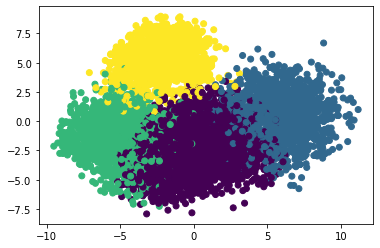

In [ ]:
PCA_components = pd.DataFrame(result)
labels = y_pred
plt.scatter(PCA_components[0], PCA_components[1], c=labels)
plt.show()

## **RoBerta :**

In [ ]:
model = SentenceTransformer('sentence-transformers/roberta-base-nli-stsb-mean-tokens')

Downloading:   0%|          | 0.00/748 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.00k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/688 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/334 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
sentence_embedding = model.encode(abstract) #prend bcp de temps +30mn !!

In [ ]:
pca = PCA(n_components=10)
result = pca.fit_transform(sentence_embedding)

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0,n_init=5).fit(result)
y_pred = kmeans.labels_
labels_all, u  = pd.factorize(df["label"])
print('RoBert Kmeans clustering  accuracy : ',accuracy_score(labels_all,y_pred))

In [ ]:
PCA_components = pd.DataFrame(result)
labels = y_pred
plt.scatter(PCA_components[0], PCA_components[1], c=labels)
plt.show()

#Dataset BBC

##Load Data

In [43]:
df_BBC = pd.read_csv('/content/bbc.csv',header=0,index_col=0)
df_BBC

In [ ]:
df_BBC["label"].value_counts().to_frame()

,label
sport,511
business,510
politics,417
tech,401
entertainment,386


In [ ]:
#punctuations
punctuations = string.punctuation
#stopwords
stop_words = list(STOP_WORDS)
def clean_text(
  string : str,
  ponctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~',
  stop_words = stop_words)->str : 

  #URLs
  string = re.sub(r"https?://\S+|www\.\S+",'',string)
  #html 
  string = re.sub(r'<.*?>','',string)
  #Numbers
  string = re.sub(r'[0-9]+','',string) 

  #Remove punctuations
  for x in string.lower():
    if x in punctuations:
      string = string.replace(x,"")
  #To lower
  string = string.lower()
  #Remove stop words
  lemmatizer = WordNetLemmatizer()
  string = ' '.join([lemmatizer.lemmatize(word) for word in string.split() if word not in stop_words])
  #Cleaning the whitespaces
  string = re.sub(r'\s', ' ', string).strip()

  return string

In [ ]:
abstract_BBC = df_BBC['text'].to_list()
abstracts_cleaned_BBC = [clean_text(x) for x in abstract_BBC]

In [ ]:
len(abstracts_cleaned_BBC)

2225

## **Word2Vec :**

### **Document embedding :**

In [ ]:
true_labels, u  = pd.factorize(df_BBC['label'])
sentances_BBC = [list(tokenize(s, deacc=True, lower=True)) for s in abstracts_cleaned_BBC]
len(sentances_BBC)

2225

In [ ]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
!gzip -d GoogleNews-vectors-negative300.bin.gz

--2021-12-04 10:21:45--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.18.142
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.18.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  30.8MB/s    in 52s     

2021-12-04 10:22:37 (30.1 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
# Load Google's pre-trained Word2Vec model.
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
#from gensim.models import KeyedVectors

#model_2 = Word2Vec(size=300, min_count=1)
#model_2.build_vocab(sentances)
#total_examples = model_2.corpus_count
#model = KeyedVectors.load_word2vec_format("/content/GoogleNews-vectors-negative300.bin", binary=True)
#model_2.intersect_word2vec_format("/content/GoogleNews-vectors-negative300.bin", binary=True, lockf=1.0)
#model_2.train(sentances, total_examples=total_examples, epochs=model_2.iter)

In [ ]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs_BBC = vectorize(sentances_BBC, model=model)
len(vectorized_docs_BBC), len(vectorized_docs_BBC[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


(2225, 300)

### **Réduction de la dimension :**

In [ ]:
reduced_data = {}
reduced_data['original'] = vectorized_docs_BBC

#### **PCA** :

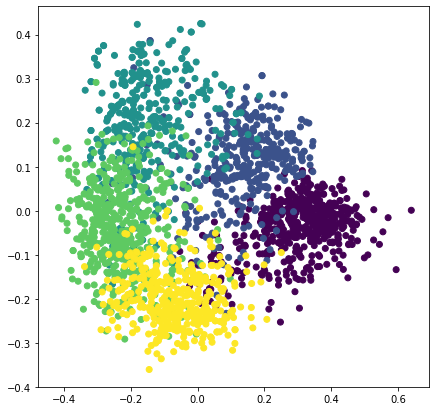

In [ ]:
pca = PCA(n_components=3)
pca_components = pca.fit_transform(vectorized_docs_BBC)
reduced_data["PCA"] = pca_components

#---------------plot----------------------------------

f = plt.figure(figsize=(7,7))
PCA_components = pd.DataFrame(pca_components)
plt.scatter(PCA_components[0], PCA_components[1],c=true_labels)
plt.show()

#### **T-SNE :**

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


tsne init = 'pca'


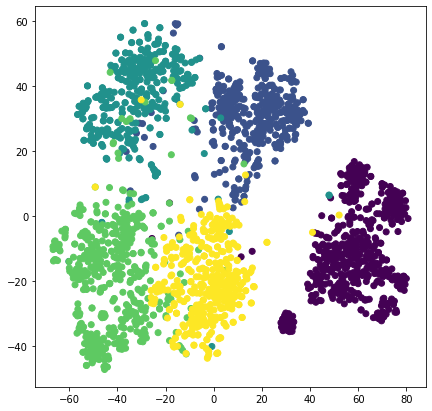

In [ ]:
tsne_components = TSNE(n_components=2,init='pca').fit_transform(vectorized_docs_BBC)
reduced_data["TSNE"] = tsne_components

#------------------plot-----------------

f = plt.figure(figsize=(7,7))
print("tsne init = 'pca'")
TSNE_components = pd.DataFrame(tsne_components) #tsne with inti ='pca'
plt.scatter(TSNE_components[0], TSNE_components[1],c=true_labels)
plt.show()

#### **UMAP :**

In [ ]:
!pip install umap-learn
import umap

     |████████████████████████████████| 86 kB 4.0 MB/s 
     |████████████████████████████████| 1.1 MB 22.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=4ab058e21a112bc14efb91ae921aeaf1c6a20980cb23acd595c84e0a349cebfd
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=d9aa5b4ee1b7dab9f1978e4e7b8dd1524b0fb18c817d40c3b14705b865d85f03
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


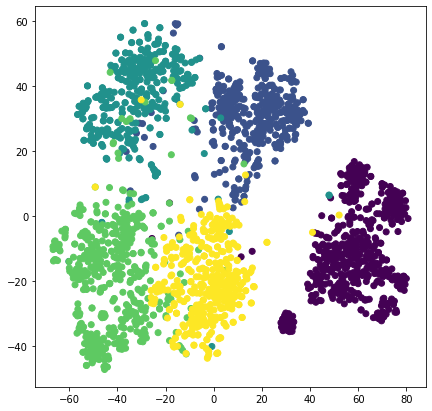

In [ ]:
reducer = umap.UMAP()
umap_components = reducer.fit_transform(vectorized_docs_BBC)
reduced_data["UMAP"] = umap_components
umap_components.shape

#----------------plot---------------------
f = plt.figure(figsize=(7,7))
UMAP_components = pd.DataFrame(umap_components) 
plt.scatter(TSNE_components[0], TSNE_components[1],c=true_labels)
plt.show()

#### **Autoencoders :**

In [ ]:
#Pas encore

### **Clustering :**

#### **K-means :**

original  Data
plot with predicted labels


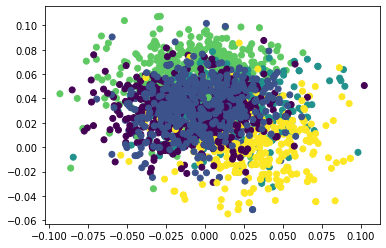

plot with true labels


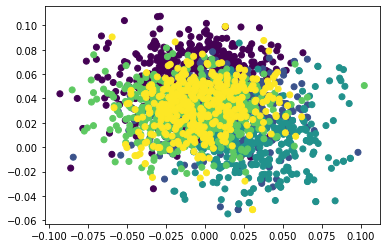

Word2vec : Kmeans clustering on  original  data accuracy :  0.019325842696629212
Word2vec : Kmeans clustering on  original  data NMI :  0.7640699172155597
Word2vec : Kmeans clustering on  original  data ARI :  0.763933174851639
________________________________________________________________________________________________________
PCA  Data
plot with predicted labels


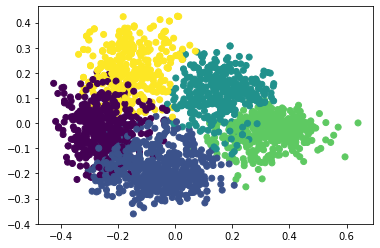

plot with true labels


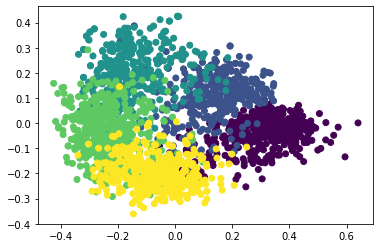

Word2vec : Kmeans clustering on  PCA  data accuracy :  0.0301123595505618
Word2vec : Kmeans clustering on  PCA  data NMI :  0.7188996521823253
Word2vec : Kmeans clustering on  PCA  data ARI :  0.7124450445479599
________________________________________________________________________________________________________
TSNE  Data
plot with predicted labels


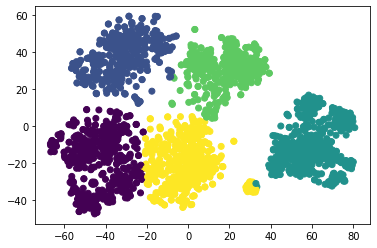

plot with true labels


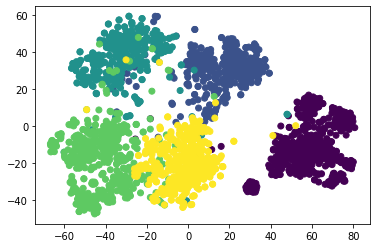

Word2vec : Kmeans clustering on  TSNE  data accuracy :  0.18741573033707865
Word2vec : Kmeans clustering on  TSNE  data NMI :  0.8354678742749813
Word2vec : Kmeans clustering on  TSNE  data ARI :  0.8581436039369847
________________________________________________________________________________________________________
UMAP  Data
plot with predicted labels


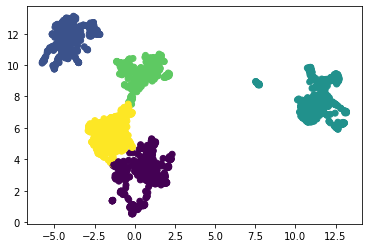

plot with true labels


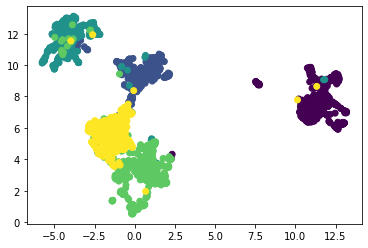

Word2vec : Kmeans clustering on  UMAP  data accuracy :  0.190561797752809
Word2vec : Kmeans clustering on  UMAP  data NMI :  0.8622221962473101
Word2vec : Kmeans clustering on  UMAP  data ARI :  0.8875866394496494
________________________________________________________________________________________________________


In [ ]:
def kmeans_runner(key,K,true_labels):
  kmeans = KMeans(n_clusters=K, random_state=0,n_init=5).fit(reduced_data[key])
  y_pred = kmeans.labels_
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  labels = y_pred
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=labels)
  plt.show()

  #-------
  labels = y_pred
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Word2vec : Kmeans clustering on ',key,' data accuracy : ',accuracy_score(true_labels,y_pred))
  print('Word2vec : Kmeans clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,y_pred))
  print('Word2vec : Kmeans clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,y_pred))
  

  print("________________________________________________________________________________________________________")


K = 5
for a in reduced_data.keys():
  kmeans_runner(a,K,true_labels)

#### **Spectral clustering :**

original
original  Data
plot with predicted labels


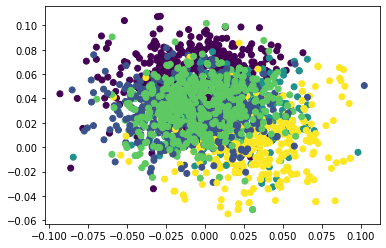

plot with true labels


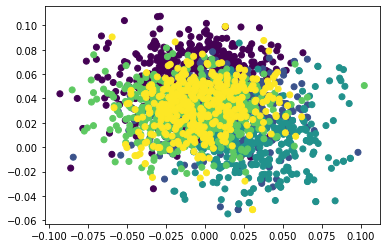

Word2vec : spectral clustering on  original  data accuracy :  0.25303370786516854
Word2vec : spectral clustering on  original  data NMI :  0.7690621907862331
Word2vec : spectral clustering on  original  data ARI :  0.7687600032705114
________________________________________________________________________________________________________
PCA
PCA  Data
plot with predicted labels


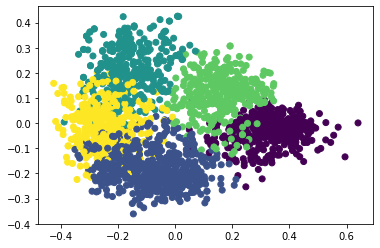

plot with true labels


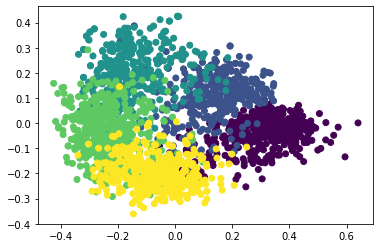

Word2vec : spectral clustering on  PCA  data accuracy :  0.37258426966292135
Word2vec : spectral clustering on  PCA  data NMI :  0.7107058649320812
Word2vec : spectral clustering on  PCA  data ARI :  0.6938303791014954
________________________________________________________________________________________________________
TSNE


KeyboardInterrupt: ignored

In [ ]:
def spec_clust_runner(key,K,true_labels):

  spectral_clust = SpectralClustering(n_clusters=K,assign_labels='discretize',random_state=0).fit(reduced_data[key])
  y_pred = spectral_clust.labels_
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  labels = y_pred
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=labels)
  plt.show()
  #-------
  labels = y_pred
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Word2vec : spectral clustering on ',key,' data accuracy : ',accuracy_score(true_labels,y_pred))
  print('Word2vec : spectral clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,y_pred))
  print('Word2vec : spectral clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,y_pred))
  

  print("________________________________________________________________________________________________________")



K = 5
for a in reduced_data.keys():
  spec_clust_runner(a,K,true_labels)

#### **HDBSCAN :**

In [ ]:
!pip install hdbscan
import hdbscan

original  Data
plot with predicted labels


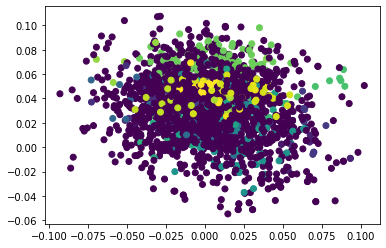

plot with true labels


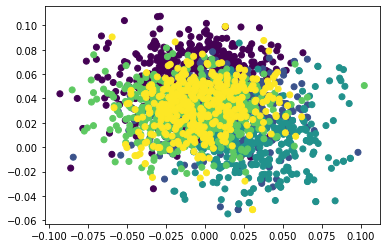

Word2vec : hdbscan clustering on  original  data accuracy :  0.01707865168539326
Word2vec : hdbscan clustering on  original  data NMI :  0.26717399111258155
Word2vec : hdbscan clustering on  original  data ARI :  0.017207953100042254
________________________________________________________________________________________________________
PCA  Data
plot with predicted labels


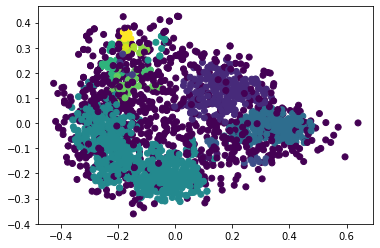

plot with true labels


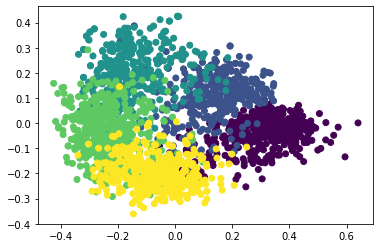

Word2vec : hdbscan clustering on  PCA  data accuracy :  0.11101123595505619
Word2vec : hdbscan clustering on  PCA  data NMI :  0.44504006374951255
Word2vec : hdbscan clustering on  PCA  data ARI :  0.28035411967568025
________________________________________________________________________________________________________
TSNE  Data
plot with predicted labels


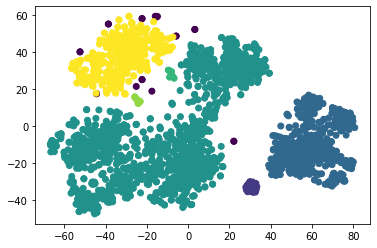

plot with true labels


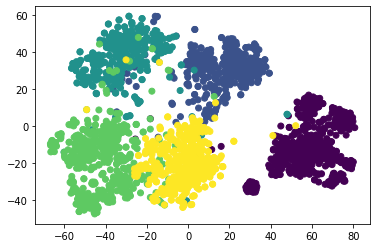

Word2vec : hdbscan clustering on  TSNE  data accuracy :  0.021123595505617977
Word2vec : hdbscan clustering on  TSNE  data NMI :  0.6334512788002087
Word2vec : hdbscan clustering on  TSNE  data ARI :  0.4418423172232203
________________________________________________________________________________________________________
UMAP  Data
plot with predicted labels


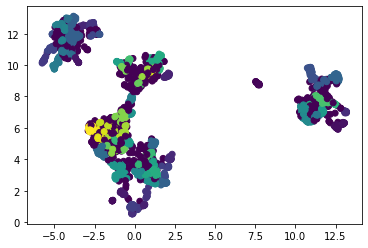

plot with true labels


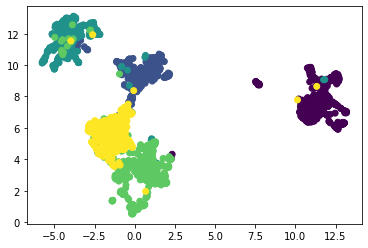

Word2vec : hdbscan clustering on  UMAP  data accuracy :  0.0035955056179775282
Word2vec : hdbscan clustering on  UMAP  data NMI :  0.4122880192492184
Word2vec : hdbscan clustering on  UMAP  data ARI :  0.05421024916318435
________________________________________________________________________________________________________


In [ ]:
def hdbscan_runner(key,true_labels):
  hdbscan_clust = hdbscan.HDBSCAN().fit(reduced_data[key])
  y_pred = hdbscan_clust.labels_
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  labels = y_pred
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=labels)
  plt.show()
  #-------
  labels = y_pred
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Word2vec : hdbscan clustering on ',key,' data accuracy : ',accuracy_score(true_labels,y_pred))
  print('Word2vec : hdbscan clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,y_pred))
  print('Word2vec : hdbscan clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,y_pred))
  

  print("________________________________________________________________________________________________________")



K = 5
for a in reduced_data.keys():
  hdbscan_runner(a,true_labels)

#### **CAH :**

original  Data
plot with predicted labels


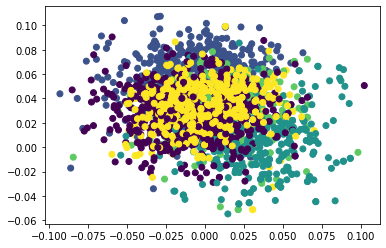

plot with true labels


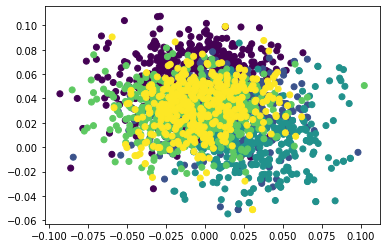

Word2vec : cah clustering on  original  data accuracy :  0.3096629213483146
Word2vec : cah clustering on  original  data NMI :  0.7447525330268314
Word2vec : cah clustering on  original  data ARI :  0.7364418657797974
________________________________________________________________________________________________________
PCA  Data
plot with predicted labels


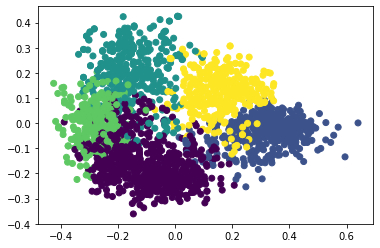

plot with true labels


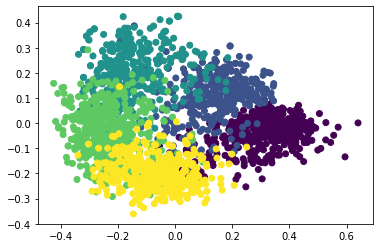

Word2vec : cah clustering on  PCA  data accuracy :  0.28719101123595503
Word2vec : cah clustering on  PCA  data NMI :  0.6907153489086992
Word2vec : cah clustering on  PCA  data ARI :  0.6300548875726691
________________________________________________________________________________________________________
TSNE  Data
plot with predicted labels


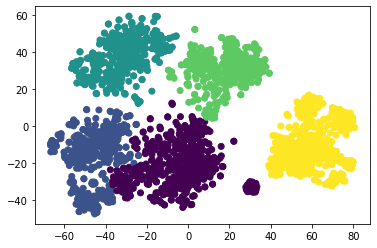

plot with true labels


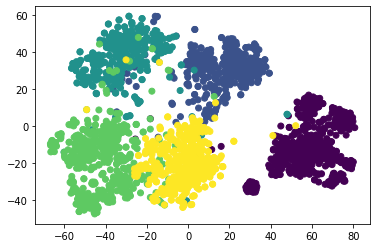

Word2vec : cah clustering on  TSNE  data accuracy :  0.18831460674157302
Word2vec : cah clustering on  TSNE  data NMI :  0.8015993194928023
Word2vec : cah clustering on  TSNE  data ARI :  0.7940127400550866
________________________________________________________________________________________________________
UMAP  Data
plot with predicted labels


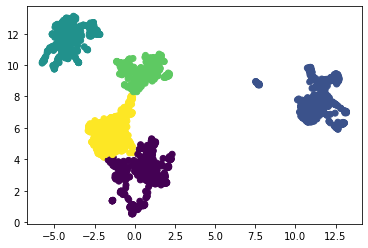

plot with true labels


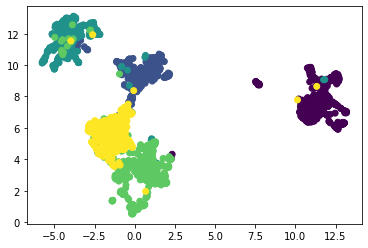

Word2vec : cah clustering on  UMAP  data accuracy :  0.35235955056179774
Word2vec : cah clustering on  UMAP  data NMI :  0.8475013901242645
Word2vec : cah clustering on  UMAP  data ARI :  0.8742531699436182
________________________________________________________________________________________________________


In [ ]:
def cah_runner(key,K,true_labels):
  y_pred = AgglomerativeClustering(n_clusters = K).fit_predict(reduced_data[key])
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  labels = y_pred
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=labels)
  plt.show()
  #-------
  labels = y_pred
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Word2vec : cah clustering on ',key,' data accuracy : ',accuracy_score(true_labels,y_pred))
  print('Word2vec : cah clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,y_pred))
  print('Word2vec : cah clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,y_pred))
  

  print("________________________________________________________________________________________________________")



K = 5
for a in reduced_data.keys():
  cah_runner(a,K,true_labels)

In [ ]:
del()

## **Glove :**

In [ ]:
!wget -c "https://nlp.stanford.edu/data/glove.840B.300d.zip"
!unzip glove*.zip

--2021-12-04 11:18:22--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2021-12-04 11:18:23--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip]
Saving to: ‘glove.840B.300d.zip’

glove.840B.300d.zip 100%[===================>]   2.03G  5.13MB/s    in 6m 52s  

2021-12-04 11:25:15 (5.04 MB/s) - ‘glove.840B.300d.zip’ saved [2176768927/2176768927]

Archive:  glove.840B.300d.zip
  inflating: glove.840B.300d.txt     



In [ ]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = datapath("/content/glove.840B.300d.txt")
tmp_file = get_tmpfile("test_word2vec.txt")
_ = glove2word2vec(glove_file, tmp_file)
model = KeyedVectors.load_word2vec_format(tmp_file)

KeyboardInterrupt: ignored

In [ ]:
vectorized_docs = vectorize(sentances, model=model)
len(vectorized_docs), len(vectorized_docs[0])

In [ ]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

### **Réduction de la dimension :**

In [ ]:
reduced_data = {}
reduced_data['original'] = vectorized_docs

#### **PCA** :

In [ ]:
pca = PCA(n_components=3)
pca_components = pca.fit_transform(vectorized_docs)
reduced_data["PCA"] = pca_components

#---------------plot----------------------------------

f = plt.figure(figsize=(7,7))
PCA_components = pd.DataFrame(pca_components)
plt.scatter(PCA_components[0], PCA_components[1],c=true_labels)
plt.show()

#### **T-SNE :**

In [ ]:
tsne_components = TSNE(n_components=2,init='pca').fit_transform(vectorized_docs)
reduced_data["TSNE"] = tsne_components

#------------------plot-----------------

f = plt.figure(figsize=(7,7))
print("tsne init = 'pca'")
TSNE_components = pd.DataFrame(tsne_components) #tsne with inti ='pca'
plt.scatter(TSNE_components[0], TSNE_components[1],c=true_labels)
plt.show()

#### **UMAP :**

In [ ]:
!pip install umap-learn
import umap

In [ ]:
reducer = umap.UMAP()
umap_components = reducer.fit_transform(vectorized_docs)
reduced_data["UMAP"] = umap_components
umap_components.shape

#----------------plot---------------------
f = plt.figure(figsize=(7,7))
UMAP_components = pd.DataFrame(umap_components) 
plt.scatter(TSNE_components[0], TSNE_components[1],c=true_labels)
plt.show()

#### **Autoencoders :**

In [ ]:
#Pas encore

### **Clustering :**

#### **K-means :**

In [1]:
def kmeans_runner(key,K,true_labels):
  kmeans = KMeans(n_clusters=K, random_state=0,n_init=5).fit(reduced_data[key])
  y_pred = kmeans.labels_
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  labels = y_pred
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=labels)
  plt.show()

  #-------
  labels = y_pred
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Glove : Kmeans clustering on ',key,' data accuracy : ',accuracy_score(true_labels,y_pred))
  print('Glove : Kmeans clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,y_pred))
  print('Glove : Kmeans clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,y_pred))
  

  print("________________________________________________________________________________________________________")


K = 5
for a in reduced_data.keys():
  kmeans_runner(a,K,true_labels)

NameError: ignored

#### **Spectral clustering :**

In [ ]:
def spec_clust_runner(key,K,true_labels):

  spectral_clust = SpectralClustering(n_clusters=K,assign_labels='discretize',random_state=0).fit(reduced_data[key])
  y_pred = spectral_clust.labels_
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  labels = y_pred
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=labels)
  plt.show()
  #-------
  labels = y_pred
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Glove : spectral clustering on ',key,' data accuracy : ',accuracy_score(true_labels,y_pred))
  print('Glove : spectral clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,y_pred))
  print('Glove : spectral clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,y_pred))
  

  print("________________________________________________________________________________________________________")



K = 5
for a in reduced_data.keys():
  spec_clust_runner(a,K,true_labels)

#### **HDBSCAN :**

In [ ]:
!pip install hdbscan
import hdbscan

In [ ]:
def hdbscan_runner(key,true_labels):
  hdbscan_clust = hdbscan.HDBSCAN().fit(reduced_data[key])
  y_pred = hdbscan_clust.labels_
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  labels = y_pred
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=labels)
  plt.show()
  #-------
  labels = y_pred
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Glove : hdbscan clustering on ',key,' data accuracy : ',accuracy_score(true_labels,y_pred))
  print('Glove : hdbscan clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,y_pred))
  print('Glove : hdbscan clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,y_pred))
  

  print("________________________________________________________________________________________________________")



K = 5
for a in reduced_data.keys():
  hdbscan_runner(a,true_labels)

#### **CAH :**

In [ ]:
def cah_runner(key,K,true_labels):
  y_pred = AgglomerativeClustering(n_clusters = K).fit_predict(reduced_data[key])
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  labels = y_pred
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=labels)
  plt.show()
  #-------
  labels = y_pred
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Glove : cah clustering on ',key,' data accuracy : ',accuracy_score(true_labels,y_pred))
  print('Glove : cah clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,y_pred))
  print('Glove : cah clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,y_pred))
  

  print("________________________________________________________________________________________________________")



K = 5
for a in reduced_data.keys():
  cah_runner(a,K,true_labels)

#Partie 2 :

##Mira's code :

In [13]:
import os
import math
import numpy as np
import tensorflow.compat.v1 as tf
from sklearn.cluster import KMeans
from tqdm import tqdm

"""
  Credits:
    This code is based on the implementation provided by Maziar Moradi Fard and Thibaut Thonet
    Available in: https://github.com/MaziarMF/deep-k-means
"""

TF_FLOAT_TYPE = tf.float32

tf.disable_eager_execution()

def fc_layers(input, specs):
    [dimensions, activations, names] = specs
    for dimension, activation, name in zip(dimensions, activations, names):
        input = tf.layers.dense(inputs=input, units=dimension, activation=activation, name=name, reuse=tf.AUTO_REUSE)
    return input

def autoencoder(input, specs):
    [dimensions, activations, names] = specs
    mid_ind = int(len(dimensions)/2)

    # Encoder
    embedding = fc_layers(input, [dimensions[:mid_ind], activations[:mid_ind], names[:mid_ind]])
    # Decoder
    output = fc_layers(embedding, [dimensions[mid_ind:], activations[mid_ind:], names[mid_ind:]])

    return embedding, output

def f_func(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=1)

def g_func(x, y):
    return tf.reduce_sum(tf.square(x - y), axis=1)

def next_batch(num, data):
    """
    Return a total of `num` random samples.
    """
    indices = np.arange(0, data.shape[0])
    np.random.shuffle(indices)
    indices = indices[:num]
    batch_data = np.asarray([data[i, :] for i in indices])

    return indices, batch_data


#######################################################
############### Deep Clustering Network ###############
#######################################################

class DcnCompGraph(object):
    """Computation graph for the Deep Clustering Network model proposed in:
        Yang, B., Fu, X., Sidiropoulos, N. D., & Hong, M. (2017). Towards K-means-friendly Spaces: Simultaneous Deep
        Learning and Clustering. In ICML '17 (pp. 3861–3870).
    This implementation is inspired by https://github.com/boyangumn/DCN
    """

    def __init__(self, ae_specs, n_clusters, batch_size, n_samples, val_lambda):
        input_size = ae_specs[0][-1]
        embedding_size = ae_specs[0][int((len(ae_specs[0]) - 1) / 2)]

        # Placeholder tensor for input data
        self.input = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=(batch_size, input_size))

        # Auto-encoder loss computations
        self.embedding, self.output = autoencoder(self.input, ae_specs)  # Get the auto-encoder's embedding and output
        rec_error = g_func(self.input, self.output)  # Reconstruction error based on distance g
        self.ae_loss = tf.reduce_mean(rec_error)

        # Clustering loss computations
        ## Tensor for cluster representatives
        minval_rep, maxval_rep = -1, 1
        self.cluster_rep = tf.Variable(tf.random_uniform([n_clusters, embedding_size],
                                                    minval=minval_rep, maxval=maxval_rep,
                                                    dtype=TF_FLOAT_TYPE), name='cluster_rep', dtype=TF_FLOAT_TYPE)

        ## Clustering assignments for all samples in the dataset
        initial_clustering_assign = tf.random_uniform(minval=0, maxval=n_clusters, dtype=tf.int32, shape=[n_samples])
        self.cluster_assign = tf.Variable(initial_clustering_assign, name='cluster_assign', dtype=tf.int32, trainable=False)

        ## Get the cluster representative corresponding to the cluster of each batch sample
        self.indices = tf.placeholder(dtype=tf.int32, shape=batch_size)  # Placeholder for sample indices in current batch
        batch_clust_rep = []
        for j in range(batch_size):
            k = self.cluster_assign[self.indices[j]]  # Clustering assignment for sample j in batch
            batch_clust_rep.append(self.cluster_rep[k, :])
        stack_batch_clust_rep = tf.stack(batch_clust_rep)

        ## Compute the k-means term
        clustering_error = f_func(self.embedding, stack_batch_clust_rep)

        # Compute the full loss combining the reconstruction error and k-means term
        self.ae_loss = tf.reduce_mean(rec_error)
        self.kmeans_loss = tf.reduce_mean(clustering_error)
        self.loss = self.ae_loss + val_lambda * self.kmeans_loss

        # The optimizer is defined to minimize this loss
        optimizer = tf.train.AdamOptimizer()
        self.pretrain_op = optimizer.minimize(self.ae_loss) # Pretrain the autoencoder before starting DCN
        self.train_op = optimizer.minimize(self.loss)

        # As it has been pointed out in the DCN paper, first the weights of the autoencoder shall be trained then the
        # assignments and cluster representatives. So far in the computation graph we have optimized the weights of the
        # autoencoder, now it's the time for the assignments and representatives.

        # Update the clustering assignments
        for j in range(batch_size):
            # Find which cluster representative is the closest to the current batch sample
            new_assign = tf.argmin(f_func(tf.reshape(self.embedding[j, :], (1, embedding_size)), self.cluster_rep),
                                   output_type=tf.int32)
            # Update the clustering assignment
            self.cluster_assign_update = tf.assign(self.cluster_assign[self.indices[j]], new_assign)

        # Update the cluster representatives
        ## Initialize the value of count
        initial_count = tf.constant(100.0, shape=[n_clusters])
        count = tf.Variable(initial_count, name='count', dtype=TF_FLOAT_TYPE, trainable=False)
        ## Update the cluster representatives according to Equation (8) in the DCN paper
        for j in range(batch_size):
            k = self.cluster_assign[self.indices[j]]  # Clustering assignment for sample j in batch
            self.count_update = tf.assign(count[k], count[k] + 1)  # Updated count for cluster assignments
            new_rep = self.cluster_rep[k] - (1 / count[k]) * (self.cluster_rep[k] - self.embedding[j])
            self.cluster_rep_update = tf.assign(self.cluster_rep[k], new_rep)

def DCN(data, n_clusters, n_components, n_pretrain_epochs=50, n_finetuning_epochs=50, lambda_=1.0, batch_size=256, seed=None, cpu=False):
    # Auto-encoder architecture
    input_size = data.shape[1]
    hidden_1_size = 500
    hidden_2_size = 500
    hidden_3_size = 2000
    embedding_size = n_components
    dimensions = [hidden_1_size, hidden_2_size, hidden_3_size, embedding_size, # Encoder layer dimensions
                  hidden_3_size, hidden_2_size, hidden_1_size, input_size] # Decoder layer dimensions
    activations = [tf.nn.relu, tf.nn.relu, tf.nn.relu, None, # Encoder layer activations
                  tf.nn.relu, tf.nn.relu, tf.nn.relu, None] # Decoder layer activations
    names = ['enc_hidden_1', 'enc_hidden_2', 'enc_hidden_3', 'embedding', # Encoder layer names
            'dec_hidden_1', 'dec_hidden_2', 'dec_hidden_3', 'output'] # Decoder layer names

    n_samples = data.shape[0]
    n_batches = int(math.ceil(n_samples / batch_size)) # Number of mini-batches
    pretrain = True # Specify if DKM's autoencoder should be pretrained

    # Hardware specifications
    if cpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Run on CPU instead of GPU if batch_size is small
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.05)

    if seed is not None:
      tf.reset_default_graph()
      tf.set_random_seed(seed)
      np.random.seed(seed)

    cg = DcnCompGraph([dimensions, activations, names], n_clusters, batch_size, n_samples,
                      lambda_)

    # Run the computation graph
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        # Initialization
        init = tf.global_variables_initializer()
        sess.run(init)

        # Pretrain if specified
        if pretrain:
            print("Starting autoencoder pretraining...")

            # Variables to save pretraining tensor content
            embeddings = np.zeros((n_samples, embedding_size), dtype=float)

            # First, pretrain the autoencoder
            ## Loop over epochs
            for _ in tqdm(range(n_pretrain_epochs)):

                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices_, data_batch = next_batch(batch_size, data)

                    # Run the computation graph until pretrain_op (only on autoencoder) on the data batch
                    _, embedding_, ae_loss_ = sess.run((cg.pretrain_op, cg.embedding, cg.ae_loss),
                                                       feed_dict={cg.input: data_batch})

                    # Save the embeddings for batch samples
                    for j in range(len(indices_)):
                        embeddings[indices_[j], :] = embedding_[j, :]

            # Second, run k-means++ on the pretrained embeddings
            print("Running k-means on the learned embeddings...")
            kmeans_model = KMeans(n_clusters=n_clusters, init="k-means++").fit(embeddings)

            # The cluster centers are used to initialize the cluster representatives in DCN
            sess.run(tf.assign(cg.cluster_rep, kmeans_model.cluster_centers_))

            # The clustering assignments are used to initialize the clustering assignments in DCN
            sess.run(tf.assign(cg.cluster_assign, kmeans_model.labels_))

        # Train the full DCN model
        print("Starting DCN training...")
        ## Loop over epochs
        for epoch in tqdm(range(n_finetuning_epochs)):
            # print("Training step: epoch {}".format(epoch))

            # Loop over the samples
            for _ in range(n_batches):
                # Fetch a random data batch of the specified size
                indices_, data_batch = next_batch(batch_size, data)

                # Run the computation graph on the data batch
                _, _, _, _, loss_, cluster_assign_, ae_loss_, kmeans_loss_ =\
                    sess.run((cg.train_op, cg.cluster_assign_update, cg.count_update, cg.cluster_rep_update, cg.loss,
                              cg.cluster_assign, cg.ae_loss, cg.kmeans_loss),
                             feed_dict={cg.input: data_batch, cg.indices: indices_})
        
        embeddings = np.zeros((n_samples, embedding_size), dtype=float)
        for _ in range(n_batches):
            # Fetch a random data batch of the specified size
            indices_, data_batch = next_batch(batch_size, data)

            # Run the computation graph on the data batch
            _, _, embeddings_, _, _, loss_, cluster_assign_, ae_loss_, kmeans_loss_ =\
                sess.run((cg.train_op, cg.cluster_assign_update, cg.embedding, cg.count_update, cg.cluster_rep_update, cg.loss,
                          cg.cluster_assign, cg.ae_loss, cg.kmeans_loss),
                          feed_dict={cg.input: data_batch, cg.indices: indices_})

            for j in range(len(indices_)):
                embeddings[indices_[j], :] = embeddings_[j, :]
                
    return embeddings, cluster_assign_


#######################################################
##################### Deep K-means ####################
#######################################################

class DkmCompGraph(object):
    """Computation graph for Deep K-Means
    """

    def __init__(self, ae_specs, n_clusters, val_lambda):
        input_size = ae_specs[0][-1]
        embedding_size = ae_specs[0][int((len(ae_specs[0])-1)/2)]

        # Placeholder tensor for input data
        self.input = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=(None, input_size))

        # Auto-encoder loss computations
        self.embedding, self.output = autoencoder(self.input, ae_specs)  # Get the auto-encoder's embedding and output
        rec_error = g_func(self.input, self.output)  # Reconstruction error based on distance g

        # k-Means loss computations
        ## Tensor for cluster representatives
        minval_rep, maxval_rep = -1, 1
        self.cluster_rep = tf.Variable(tf.random_uniform([n_clusters, embedding_size],
                                                    minval=minval_rep, maxval=maxval_rep,
                                                    dtype=TF_FLOAT_TYPE), name='cluster_rep', dtype=TF_FLOAT_TYPE)

        ## First, compute the distance f between the embedding and each cluster representative
        list_dist = []
        for i in range(0, n_clusters):
            dist = f_func(self.embedding, tf.reshape(self.cluster_rep[i, :], (1, embedding_size)))
            list_dist.append(dist)
        self.stack_dist = tf.stack(list_dist)

        ## Second, find the minimum squared distance for softmax normalization
        min_dist = tf.reduce_min(list_dist, axis=0)

        ## Third, compute exponentials shifted with min_dist to avoid underflow (0/0) issues in softmaxes
        self.alpha = tf.placeholder(dtype=TF_FLOAT_TYPE, shape=())  # Placeholder tensor for alpha
        list_exp = []
        for i in range(n_clusters):
            exp = tf.exp(-self.alpha * (self.stack_dist[i] - min_dist))
            list_exp.append(exp)
        stack_exp = tf.stack(list_exp)
        sum_exponentials = tf.reduce_sum(stack_exp, axis=0)

        ## Fourth, compute softmaxes and the embedding/representative distances weighted by softmax
        list_softmax = []
        list_weighted_dist = []
        for j in range(n_clusters):
            softmax = stack_exp[j] / sum_exponentials
            weighted_dist = self.stack_dist[j] * softmax
            list_softmax.append(softmax)
            list_weighted_dist.append(weighted_dist)
        stack_weighted_dist = tf.stack(list_weighted_dist)

        # Compute the full loss combining the reconstruction error and k-means term
        self.ae_loss = tf.reduce_mean(rec_error)
        self.kmeans_loss = tf.reduce_mean(tf.reduce_sum(stack_weighted_dist, axis=0))
        self.loss = self.ae_loss + val_lambda * self.kmeans_loss

        # The optimizer is defined to minimize this loss
        optimizer = tf.train.AdamOptimizer()
        self.pretrain_op = optimizer.minimize(self.ae_loss) # Pretrain the autoencoder before starting DKM
        self.train_op = optimizer.minimize(self.loss) # Train the whole DKM model

def DKM(data, n_clusters, n_components, n_pretrain_epochs=50, n_finetuning_epochs=5, lambda_=1.0, batch_size=256, seed=None, cpu=False):
    """
        The final number of finetuning epochs is n_finetuning_epochs * 20 if pretrain and n_finetuning_epochs * 40 if annealing
    """
    # Auto-encoder architecture
    input_size = data.shape[1]
    hidden_1_size = 500
    hidden_2_size = 500
    hidden_3_size = 2000
    embedding_size = n_components
    dimensions = [hidden_1_size, hidden_2_size, hidden_3_size, embedding_size, # Encoder layer dimensions
                  hidden_3_size, hidden_2_size, hidden_1_size, input_size] # Decoder layer dimensions
    activations = [tf.nn.relu, tf.nn.relu, tf.nn.relu, None, # Encoder layer activations
                  tf.nn.relu, tf.nn.relu, tf.nn.relu, None] # Decoder layer activations
    names = ['enc_hidden_1', 'enc_hidden_2', 'enc_hidden_3', 'embedding', # Encoder layer names
            'dec_hidden_1', 'dec_hidden_2', 'dec_hidden_3', 'output'] # Decoder layer names

    n_samples = data.shape[0]
    n_batches = int(math.ceil(n_samples / batch_size)) # Number of mini-batches
    pretrain = True # Specify if DKM's autoencoder should be pretrained
    annealing = False # Specify if annealing should be used

    # Define the alpha scheme depending on if the approach includes annealing/pretraining
    if annealing and not pretrain:
        constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
        max_n = 40  # Number of alpha values to consider
        alphas = np.zeros(max_n, dtype=float)
        alphas[0] = 0.1
        for i in range(1, max_n):
            alphas[i] = (2 ** (1 / (np.log(i + 1)) ** 2)) * alphas[i - 1]
        alphas = alphas / constant_value
    elif not annealing and pretrain:
        constant_value = 1  # specs.embedding_size # Used to modify the range of the alpha scheme
        max_n = 20  # Number of alpha values to consider (constant values are used here)
        alphas = 1000*np.ones(max_n, dtype=float) # alpha is constant
        alphas = alphas / constant_value
    else:
        raise Exception("Run with either annealing (-a) or pretraining (-p), but not both.")

    # Hardware specifications
    if cpu:
        os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # Run on CPU instead of GPU if batch_size is small

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.05)
    config = tf.ConfigProto(gpu_options=gpu_options)

    if seed is not None:
      tf.reset_default_graph()
      tf.set_random_seed(seed)
      np.random.seed(seed)
      
    # Define the computation graph for DKM
    cg = DkmCompGraph([dimensions, activations, names], n_clusters, lambda_)

    # Run the computation graph
    with tf.Session(config=config) as sess:
        # Initialization
        init = tf.global_variables_initializer()
        sess.run(init)

        # Variables to save tensor content
        distances = np.zeros((n_clusters, n_samples))

        # Pretrain if specified
        if pretrain:
            print("Starting autoencoder pretraining...")

            # Variables to save pretraining tensor content
            embeddings = np.zeros((n_samples, embedding_size), dtype=float)

            # First, pretrain the autoencoder
            ## Loop over epochs
            for _ in tqdm(range(n_pretrain_epochs)):
                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices, data_batch = next_batch(batch_size, data)

                    # Run the computation graph until pretrain_op (only on autoencoder) on the data batch
                    _, embedding_, ae_loss_ = sess.run((cg.pretrain_op, cg.embedding, cg.ae_loss),
                                                        feed_dict={cg.input: data_batch})

                    # Save the embeddings for batch samples
                    for j in range(len(indices)):
                        embeddings[indices[j], :] = embedding_[j, :]

            # Second, run k-means++ on the pretrained embeddings
            print("Running k-means on the learned embeddings...")
            kmeans_model = KMeans(n_clusters=n_clusters, init="k-means++").fit(embeddings)

            # The cluster centers are used to initialize the cluster representatives in DKM
            sess.run(tf.assign(cg.cluster_rep, kmeans_model.cluster_centers_))

        # Train the full DKM model
        if (len(alphas) > 0):
            print("Starting DKM training...")
        ## Loop over alpha (inverse temperature), from small to large values
        for k in tqdm(range(len(alphas))):
            # Loop over epochs per alpha
            for _ in range(n_finetuning_epochs):
                # Loop over the samples
                for _ in range(n_batches):
                    # Fetch a random data batch of the specified size
                    indices, data_batch = next_batch(batch_size, data)

                    # Run the computation graph on the data batch
                    _, loss_, stack_dist_, cluster_rep_, ae_loss_, kmeans_loss_ =\
                        sess.run((cg.train_op, cg.loss, cg.stack_dist, cg.cluster_rep, cg.ae_loss, cg.kmeans_loss),
                                  feed_dict={cg.input: data_batch, cg.alpha: alphas[k]})

                    # Save the distances for batch samples
                    for j in range(len(indices)):
                        distances[:, indices[j]] = stack_dist_[:, j]

        _, loss_, X_reduced, stack_dist_, cluster_rep_, ae_loss_, kmeans_loss_ =\
        sess.run((cg.train_op, cg.loss, cg.embedding, cg.stack_dist, cg.cluster_rep, cg.ae_loss, cg.kmeans_loss),
                  feed_dict={cg.input: data, cg.alpha: alphas[k]})

        distances = stack_dist_

        # Infer cluster assignments for all samples
        cluster_assign = np.zeros((n_samples), dtype=float)
        for i in range(n_samples):
            index_closest_cluster = np.argmin(distances[:, i])
            cluster_assign[i] = index_closest_cluster
        cluster_assign = cluster_assign.astype(np.int64)

    return X_reduced, cluster_assign

##Partie 2 Classic4 :

###DCN for Classic4 :

In [37]:
tf.reset_default_graph()
vectorized_docs_array = np.array(vectorized_docs)
embeddings_DCN_Classic4, cluster_assign_DCN_Classic4 = DCN(vectorized_docs_array, 4, 2, n_pretrain_epochs=50, n_finetuning_epochs=50, lambda_=1.0, batch_size=256, seed=None, cpu=False)
reduced_data = {}
reduced_data['DCN']=embeddings_DCN_Classic4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:06<00:00,  8.11it/s]


Running k-means on the learned embeddings...
Starting DCN training...


100%|██████████| 50/50 [00:20<00:00,  2.40it/s]


###DKM for classic4 :

In [38]:
tf.reset_default_graph()
vectorized_docs_array = np.array(vectorized_docs)
X_reduced_DKM_Classic4, cluster_assign_DKM_Classic4 = DKM(vectorized_docs_array, 4, 2, n_pretrain_epochs=50, n_finetuning_epochs=5, lambda_=1.0, batch_size=256, seed=None, cpu=False)
reduced_data['DKM']=X_reduced_DKM_Classic4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


Starting autoencoder pretraining...


100%|██████████| 50/50 [00:06<00:00,  8.04it/s]


Running k-means on the learned embeddings...
Starting DKM training...


100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


##Partie2 BBC:

###DCN for BBC:

In [ ]:
tf.reset_default_graph()
vectorized_docs_array = np.array(vectorized_docs)
embeddings_DCN_BBC, cluster_assign_DCN_Classic4 = DCN(vectorized_docs_array, 5, 2, n_pretrain_epochs=50, n_finetuning_epochs=50, lambda_=1.0, batch_size=256, seed=None, cpu=False)


###DKM for BBC : 

In [ ]:
tf.reset_default_graph()
vectorized_docs_array = np.array(vectorized_docs)
X_reduced_DKM_BBC, cluster_assign_DKM_Classic4 = DKM(vectorized_docs_array, 4, 2, n_pretrain_epochs=50, n_finetuning_epochs=5, lambda_=1.0, batch_size=256, seed=None, cpu=False)


##Plot Function :

DCN  Data
plot with predicted labels


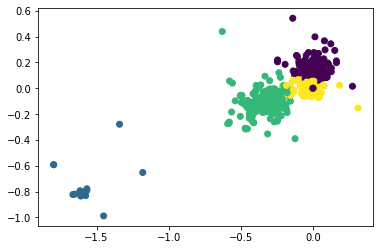

plot with true labels


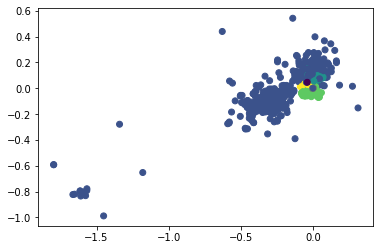

Word2vec : Kmeans clustering on  DCN  data accuracy :  0.43203722166832836
Word2vec : Kmeans clustering on  DCN  data NMI :  0.3431618692339268
Word2vec : Kmeans clustering on  DCN  data ARI :  0.16889146739718897
________________________________________________________________________________________________________
DKM  Data
plot with predicted labels


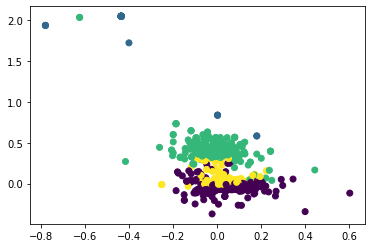

plot with true labels


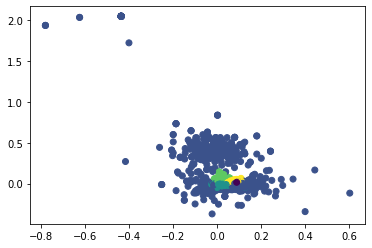

Word2vec : Kmeans clustering on  DKM  data accuracy :  0.43203722166832836
Word2vec : Kmeans clustering on  DKM  data NMI :  0.3431618692339268
Word2vec : Kmeans clustering on  DKM  data ARI :  0.16889146739718897
________________________________________________________________________________________________________


In [45]:
def plot_result(key,true_labels,predicted_labels):
  print(key," Data")
  #------------ plot---------------------------
  Components = pd.DataFrame(reduced_data[key])
  print("plot with predicted labels")
  plt.scatter(Components[0], Components[1], c=predicted_labels)
  plt.show()

  #-------
  print("plot with true labels")
  plt.scatter(Components[0], Components[1], c=true_labels)
  plt.show()

  #-------

  print('Word2vec : Kmeans clustering on ',key,' data accuracy : ',accuracy_score(true_labels,predicted_labels))
  print('Word2vec : Kmeans clustering on ',key,' data NMI : ',normalized_mutual_info_score(true_labels,predicted_labels))
  print('Word2vec : Kmeans clustering on ',key,' data ARI : ',adjusted_rand_score(true_labels,predicted_labels))
  print("________________________________________________________________________________________________________")


K = 4

for a in reduced_data.keys():
  plot_result(a,true_labels,cluster_assign_DCN_Classic4)
